In [1]:
from keras          import backend as K

from keras.layers   import Input, Lambda, Dense
from keras.models   import Model, load_model, model_from_json
from keras.datasets import mnist
from keras.losses   import binary_crossentropy

import numpy as np

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.

In [3]:
# mnist_autoencoder = load_model('mnist_autoencoder.h5',compile=False)
mnist_autoencoder = load_model('mnist_dAE.h5')

# mnist_autoencoder = model_from_json(mnist_autoencoder.to_json())

vae_latent_dim = 2

mnist_encoder = mnist_autoencoder.layers[1]
mnist_decoder = mnist_autoencoder.layers[2]

mnist_latent_dim = mnist_encoder.outputs[0].shape[1].value
# mnist_latent_dim = 512

In [4]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(x_raw, x_decoded):
    xen_loss = K.mean(binary_crossentropy(x_raw, x_decoded) * 784)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xen_loss + kl_loss

In [5]:
# _ = mnist_encoder.layers.pop()

vae_inputs = mnist_encoder(mnist_autoencoder.input)
# vae_inputs = Dense(mnist_latent_dim, name='latent_AE')(vae_inputs)

z_mean     = Dense(vae_latent_dim, name='z_mean'   )(vae_inputs)
z_log_var  = Dense(vae_latent_dim, name='z_log_var')(vae_inputs)
z          = Lambda(sampling, output_shape=(vae_latent_dim,), name='z')([z_mean, z_log_var])

vae_encoder = Model(mnist_autoencoder.input, [z_mean, z_log_var, z], name='vae_encoder')


vae_latent = Input(shape=(vae_latent_dim,), name='z_sampling')
vae_latent_output = Dense(mnist_latent_dim, name='latent_sampling', activation='relu')(vae_latent)

# mnist_decoder._layers[0].batch_input_shape = (None, mnist_latent_dim)
# mnist_decoder = model_from_json(mnist_decoder.to_json())

vae_decoder = Model(vae_latent, mnist_decoder(vae_latent_output), name='vae_decoder')


vae_input  = mnist_autoencoder.input
vae_output = vae_decoder( vae_encoder(vae_input)[2] )

vae = Model(
    inputs  = vae_input, 
    outputs = vae_output, 
    name    = 'MNIST_VAE'
)

vae.compile(optimizer='adam',loss=vae_loss)


In [6]:
history = vae.fit(
    np.expand_dims(x_train, axis=3),
    np.expand_dims(x_train, axis=3),
    epochs=200,
    batch_size=128,
    validation_data=(np.expand_dims(x_test, axis=3), np.expand_dims(x_test, axis=3)),
    verbose=2
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/200
 - 37s - loss: 172.2978 - val_loss: 157.5127
Epoch 2/200
 - 36s - loss: 155.2222 - val_loss: 151.1590
Epoch 3/200
 - 36s - loss: 150.8719 - val_loss: 148.2683
Epoch 4/200
 - 36s - loss: 148.6630 - val_loss: 147.2558
Epoch 5/200
 - 36s - loss: 147.0619 - val_loss: 145.5361
Epoch 6/200
 - 37s - loss: 145.9162 - val_loss: 144.7940
Epoch 7/200
 - 36s - loss: 144.9675 - val_loss: 143.1986
Epoch 8/200
 - 36s - loss: 144.1646 - val_loss: 142.6966
Epoch 9/200
 - 36s - loss: 143.4958 - val_loss: 143.2646
Epoch 10/200
 - 37s - loss: 143.0185 - val_loss: 142.6821
Epoch 11/200
 - 36s - loss: 142.5564 - val_loss: 141.9080
Epoch 12/200
 - 36s - loss: 142.1739 - val_loss: 141.4564
Epoch 13/200
 - 36s - loss: 142.0274 - val_loss: 140.8290
Epoch 14/200
 - 36s - loss: 141.5575 - val_loss: 140.5031
Epoch 15/200
 - 36s - loss: 141.3752 - val_loss: 140.2861
Epoch 16/200
 - 36s - loss: 141.1275 - val_loss: 140.6048
Epoch 17/200
 - 36s - loss: 140

Epoch 141/200
 - 36s - loss: 134.9159 - val_loss: 135.2580
Epoch 142/200
 - 36s - loss: 134.9784 - val_loss: 135.5399
Epoch 143/200
 - 36s - loss: 135.0029 - val_loss: 135.4258
Epoch 144/200
 - 36s - loss: 134.9331 - val_loss: 135.2528
Epoch 145/200
 - 36s - loss: 134.9966 - val_loss: 135.2673
Epoch 146/200
 - 36s - loss: 135.0076 - val_loss: 135.7249
Epoch 147/200
 - 36s - loss: 134.8576 - val_loss: 135.6645
Epoch 148/200
 - 36s - loss: 134.8420 - val_loss: 135.1871
Epoch 149/200
 - 36s - loss: 134.9653 - val_loss: 135.0031
Epoch 150/200
 - 36s - loss: 134.8669 - val_loss: 134.8645
Epoch 151/200
 - 36s - loss: 134.8361 - val_loss: 134.9517
Epoch 152/200
 - 36s - loss: 134.9166 - val_loss: 135.5700
Epoch 153/200
 - 36s - loss: 134.9068 - val_loss: 135.0387
Epoch 154/200
 - 36s - loss: 134.7427 - val_loss: 135.1502
Epoch 155/200
 - 36s - loss: 134.7673 - val_loss: 135.1222
Epoch 156/200
 - 36s - loss: 134.7508 - val_loss: 135.1307
Epoch 157/200
 - 36s - loss: 134.6766 - val_loss: 134.96

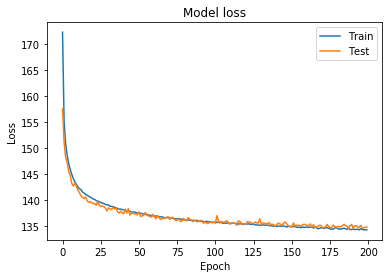

In [7]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

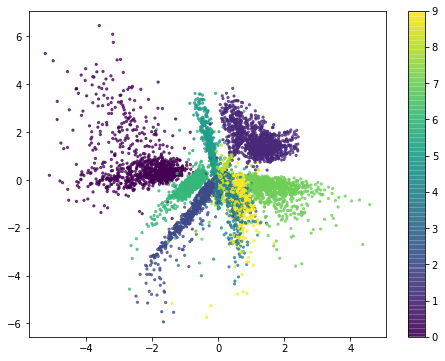

In [8]:
x_test_encoded = vae_encoder.predict(np.expand_dims(x_test, axis=3), batch_size=128)[0]
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, alpha=0.7, s=5)
plt.colorbar()
plt.show()

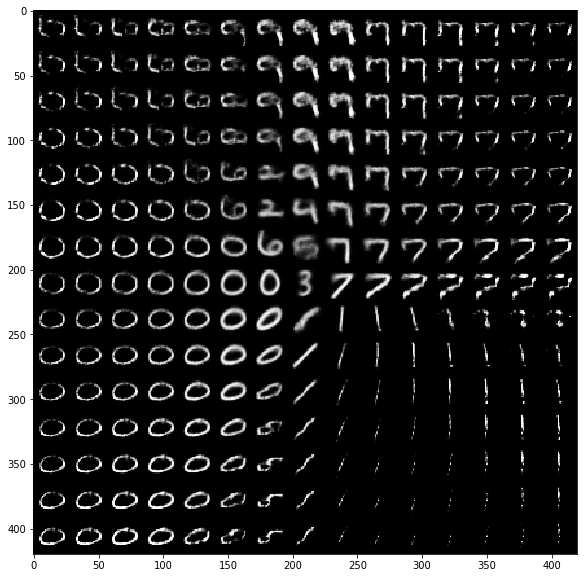

In [9]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1
        x_decoded = vae_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()